In [144]:
%matplotlib inline
import matplotlib.pylab as plt
TMPFIGPATH = "visualisation/figures/"
FIGPATH = "../../master_thesis/figures/"
import seaborn as sns
import sys, os
import numpy as np
import pandas as pd
from datetime import datetime as dt
from collections import Counter
from sklearn.preprocessing import scale
from sklearn.feature_selection import VarianceThreshold
import bandicoot_dev as bc_d
from py_pcha.PCHA import PCHA
from sklearn import decomposition
from build_dataset.analysis.compute_thetas import compute_thetas

In [4]:
# Can only be loaded remotely
from build_dataset.analysis.outlier_detection import Outlier_detector_svm, Outlier_detector_kd
from build_dataset.extractors.big_five_extractor import Big_five_extractor

In [5]:
tc0 = {
    'hours': range(24),
    'days': range(7),
    'spans': [
        ("01/01/14", "31/12/14")
    ],
    'weeks': range(53)
}
tc1 = {
    'hours': range(24),
    'days': range(7),
    'spans': [
        ("06/01/14", "24/01/14"),
        ("03/02/14", "16/05/14"),
        ("01/09/14", "05/12/14"),
        ("02/06/14", "20/06/14")
    ],
    'weeks': range(1, 4) + \
             range(5, 16) + \
             range(17, 20) + \
             range(22, 25) + \
             range(35, 40) + \
             range(41, 49)
}
tc2 = {
    'hours': range(24),
    'days': range(7),
    'spans': [
        ("17/05/14", "01/06/14"),
        ("06/12/14", "21/12/14")
    ],
    'weeks': range(20, 22) + \
             range(49, 52)
}
tc3 = {
    'hours': range(24),
    'days': range(7),
    'spans': [
        ("01/01/14", "05/01/14"),
        ("25/01/14", "02/02/14"),
        ("14/04/14", "20/04/14"),
        ("21/06/14", "30/08/14"),
        ("22/12/14", "31/12/14")
    ],
    'weeks': range(0, 1) + \
             range(4, 5) + \
             range(16, 17) + \
             range(25, 35) + \
             range(40, 41) + \
             range(52, 53)
}

## Compute features

In [208]:
class SufficiencyException(Exception):
    pass

def _threshold_test(user):
    def __recs_per_day(records):
        counter = len(records) * 1.0
        span = (max(records, key=lambda r: r.datetime).datetime - \
                min(records, key=lambda r: r.datetime).datetime).days
        if span == 0:
            return 0
        return counter/span
    
    thresholds = [
        (user.text_records, 2),
        (user.call_records, 1),
        (user.physical_records, 1),
        (user.screen_records, 20),
        (user.stop_records, 1)
    ]
    
    for records, thr in thresholds:
        if __recs_per_day(records) < thr:
            return False
    return True

def _compute_features(userid, tc="tc0", groupby="week", summary="special"):
    
    user = bc_d.read_csv(
        "%d" % userid, 
        call_path="build_dataset/data_cache/records/call/%s/" % tc,
        text_path="build_dataset/data_cache/records/text/%s/" % tc,
        physical_path="build_dataset/data_cache/records/physical/%s/" % tc,
        screen_path="build_dataset/data_cache/records/screen/%s/" % tc,
        stop_path="build_dataset/data_cache/records/stop/%s/" % tc, 
        network=False,
        describe=False
    )

    if not _threshold_test(user):
        raise SufficiencyException("User '%s' has too few records for analysis" % str(userid))
    
    user.start_time['any'] = dt.strptime('01/01/14', "%d/%m/%y")
    user.end_time['any'] = dt.strptime('01/01/15', "%d/%m/%y")
    
    indicators = bc_d.utils.all(
        user,
        groupby=groupby,
        summary=summary,
        dist=True,
        network=False,
        spatial=False
    )

    for ex in ['name', 'reporting']:
        del indicators[ex]

    return bc_d.utils.flatten(indicators), user

def _processed_users(tc):
    interaction_types = ["call", "text", "physical", "screen", "stop"]
    counter = Counter()
    for t in interaction_types:
        users = [int(f.split(".")[0]) for f in os.listdir("build_dataset/data_cache/records/%s/%s" % (t, tc))]
        counter.update(users)
    return [k for k,v in counter.items() if v == 5]

def _number_of_days(groupby):
    if groupby == "week":
        return 7
    if groupby == "month":
        return 30
    if groupby == "year":
        return 365

def _get_periods(tc, groupby):
    """Only works for tc0!"""
    period = _number_of_days(groupby)
    span = tc['spans'][0]
    delta = dt.strptime(span[1], "%d/%m/%y") - \
            dt.strptime(span[0], "%d/%m/%y")
    return int(np.ceil(delta.days/period)) + 1

def _interpolate_nans(X):
    """Overwrite NaNs with column value interpolations."""
    for j in range(X.shape[1]):
        mask_j = np.isnan(X[:,j])
        try:
            X[mask_j,j] = np.interp(np.flatnonzero(mask_j), np.flatnonzero(~mask_j), X[~mask_j,j])
        except ValueError:
            X[mask_j,j] = 0
    return X

def _variance_thresholding(X):
    """Return features with below threshold variance."""
    sel = VarianceThreshold(threshold=(0.5)).fit(X)
    return sel.get_support()
    

def make_dataset(groupby="week", tc="tc0", load_cached=True, interpolate_nans=False, variance_thresholding=False, summary="special"):
    if load_cached:
        try:
            X = np.load("data/X_2014_%s_%s.pickle" % (tc, groupby))
            Y = np.load("data/Y_2014_%s.pickle" % groupby)
            M = np.load("data/M_2014_%s.pickle" % groupby)
            feat_names = np.load("data/X_2014_%s_feat_names.pickle" % groupby)
            valid_users = np.load("data/XY_2014_%s_%s_valid_users.pickle" % (tc, groupby))
        except IOError:
            print "File not found. Building dataset..."
            load_cached = False
            
    if not load_cached:
        big_five = Big_five_extractor()
        users = _processed_users(tc)
        valid_users = []
        l = 0
        for u in sorted(users):
            print "\n", u
    
            try:
                ds, user = _compute_features(u, groupby=groupby, summary=summary)
            except SufficiencyException as e:
                print e
                continue

            # Initiate
            if l == 0:
                if groupby == None:
                    M = len(ds)
                    N = 1
                else:
                    M = len(ds) + sum([1 for v in ds.values() if type(v[0]) is dict])  # Indicators
                    N = _get_periods(tc0, groupby)
                L = len(users)
                feat_names = []
                X = np.empty((N, M, L))
                Y = np.empty((1, 5, L))

            U = np.full((N, M), None)

            c = 0
            for m, (f, vals) in enumerate(ds.items()):
                if l == 0:
                    if groupby != None and type(vals[0]) is dict:
                        feat_names.append(f + "_mean")
                        feat_names.append(f + "_std")
                    else:
                        feat_names.append(f)
                
                if groupby != None:
                    for n, v in enumerate(vals):
                        # v is either [int, int, int, ...], or [dict, dict, dict, ...]
                        if type(v) is dict:
                            U[n, m + c] = v['mean']
                            U[n, m + c + 1] = v['std']
                            increment_c = True
                        else:
                            U[n, m + c] = v
                            increment_c = False
                else:
                    U[0, m + c] = vals
                    increment_c = False

                if increment_c:
                    c += 1

            try:
                X[:, :, l] = U
                Y[:, :, l] = big_five.main(u)
                valid_users.append(u)
                l+=1
            except:
                print "User", u, "skipped"

        X = X[:, :, :l]  # Not sure if it should be :l or :l+1
        Y = Y[0, :, :l]
        M = compute_thetas(Y.T, penalty='consensus')
        
        X.dump("data/X_2014_%s_%s.pickle" % (tc, groupby))
        Y.dump("data/Y_2014_%s.pickle" % groupby)
        M.dump("data/M_2014_%s.pickle" % groupby)
        np.array(feat_names).dump("data/X_2014_%s_feat_names.pickle" % groupby)
        np.array(valid_users).dump("data/XY_2014_%s_%s_valid_users.pickle" % (tc, groupby))
        
    if interpolate_nans:
        for l in range(X.shape[2]):
            mask_i = ~np.all(np.isnan(X[:, :, l]) | np.equal(X[:, :, l], 0), axis=1)
            X[mask_i, :, l] = _interpolate_nans(X[mask_i, :, l])
            
    if variance_thresholding:
        support = _variance_thresholding(scale(np.nanmean(X, axis=2)))
        X = X[:, support, :]
        print "Removed %d traits:" % np.sum(~support)
        for r in feat_names[~support]:
            print "  * %d - %s" % (list(feat_names).index(r), r)
        feat_names = feat_names[support]

    return X, Y, M, list(feat_names), list(valid_users)

Xo, Yo, Mo, feat_nameso, valid_userso = make_dataset(groupby=None, tc="tc1", summary="default", load_cached=True, interpolate_nans=True, variance_thresholding=False)

In [447]:
feature_name_map = {
    'number_of_contacts_stop': 'Goes many different places',
    'number_of_contacts_text': 'Texts many different people',
    'number_of_contacts_call': 'Calls many different people',
    'number_of_contacts_physical': 'Meets many different people',
    'number_of_interactions_stop': 'Goes places often',
    'number_of_interactions_text': 'Texts often',
    'number_of_interactions_call': 'Calls often',
    'number_of_interactions_physical': 'Meets people often',
    'interactions_per_contact_stop': 'Goes places often compare to number of different places went',
    'interactions_per_contact_text': 'Texts people often compared to number of different people texted',
    'interactions_per_contact_call': 'Calls people often compared to number of different people called',
    'interactions_per_contact_physical': 'Meets people often compare to number of people met',
    'percent_ei_percent_interactions_text': 'Distributes texts evenly among friends',
    'percent_ei_percent_interactions_physical': 'Distributes meetings evenly among friends',
    'balance_of_interactions_text': 'Sends more texts than receives',
    'balance_of_interactions_call': 'Makes more calls then receives',
    'entropy_per_contacts_stop': 'Has unpredictable travel patterns',
    'entropy_per_contacts_text': 'Has unpredictable texting patterns',
    'entropy_per_contacts_call': 'Has unpredictable calling patterns',
    'entropy_per_contacts_physical': 'Has unpredictable social meeting patterns',
    'duration_stop': 'Spends long time at locations',
    'duration_text': 'Has long text conversations',
    'duration_screen': 'Has long phone usage sessions',
    'duration_call': 'Makes long calls',
    'duration_physical': 'Spends long times with people',
    'percent_ei_percent_durations_stop': 'Distributes time at different locations evenly',
    'percent_ei_percent_durations_call': 'Distributes calls evenly among friends',
    'percent_initiated_conversations_call+text_std': 'Starts more cell conversations with some people than with others',
    'percent_initiated_conversations_call+text_mean': 'Generally starts most cell conversations',
    'percent_concluded_conversations_call+text_std': 'Concludes more cell conversations with some people than with others',
    'percent_concluded_conversations_call+text_mean': 'Generally concludes most cell conversations',
    'overlap_conversations_per_contacts_text': 'Has text conversations with multiple people at the same time',
    'overlap_conversations_per_contacts_physical': 'Tends to hang out with multiple people at the same time',
    'response_delay_text_std': 'Will respond slower to texts for some people than others',
    'response_delay_text_mean': 'Generally responds to texts slowly',
    'response_delay_call_std': 'Will return missed calls slower for some people than others',
    'response_delay_call_mean': 'Generally responds slowly to missed calls',
    'response_rate_call+text_std': 'Tends to respond to texts and calls more often for some people than others',
    'response_rate_call+text_mean': 'Generally tends to respond to texts and calls',
    'percent_nocturnal_screen': 'Uses phone at night often',
    'percent_nocturnal_stop': 'Goes many places at night',
    'percent_nocturnal_physical': 'Meets many people at night',
    'interevent_time_screen': 'Can go long time without looking at phone',
    'fraction_social_screen_alone_screen_screen+physical': 'Tends to look at phone when among people',
    'percent_interactions_campus_physical+stop': 'Mostly meets people at the university',
    'percent_interactions_home_physical+stop': 'Mostly meets people at home',
    'percent_interactions_other_physical+stop': 'Mostly meets people outside of home and university',
    'percent_outside_campus_from_campus_physical+stop': 'Tends to meet friends from school outside of school',
    'percent_at_campus_stop': 'Shows up for class',
    'percent_at_home_stop': 'Stays at home',
    'percent_at_friday_bar_stop': 'Goes to the friday bar',
    'percent_contacts_less_physical': 'Meets many people only once',
    'first_seen_response_rate_screen+text': 'Tends to respond to texts immediately',
    'percent_concluded_conversations_call_mean': 'Generally returns missed calls',
    'percent_concluded_conversations_call_std': 'Is more likely to return missed calls for some people than others',
    'percent_concluded_conversations_text_mean': 'Generally concludes most text conversations',
    'percent_concluded_conversations_text_std': 'Is more likely to conclude text conversations with some people than others',
    'percent_contacts_less_stop': 'Goes to many places only once',
    'percent_initiated_conversations_call_mean': 'Generally initiates most phone conversations',
    'percent_initiated_conversations_call_std': 'Is more likely to initiate phone conversations for some people than others',
    'percent_initiated_conversations_text_mean': 'Generally initiate most text conversations',
    'percent_initiated_conversations_text_std': 'Is more likely to initiate text conversations with some people than others'
}

super_traits = {
    "social_circle_size": {
        'Texts many different people': 1,
        'Calls many different people': 1,
        'Meets many different people': 1
    },
    "social_engagement": {
        'Texts often': 1,
        'Calls often': 1,
        'Meets people often': 1,
        'Texts people often compared to number of different people texted': 1,
        'Calls people often compared to number of different people called': 1,
        'Meets people often compare to number of people met': 1,
        'Has long lasting text conversations': 1,
        'Makes long calls': 1,
        'Spends long times with people': 1,
        'Has text conversations with multiple people at the same time': 1,
        'Tends to hang out with multiple people at the same time': 1
    },
    "social_coreness": {
        'Distributes texts evenly among friends': -1,
        'Distributes meetings evenly among friends': -1,
        'Distributes calls evenly among friends': -1,
        'Has unpredictable texting patterns': -1,
        'Has unpredictable calling patterns': -1,
        'Has unpredictable social meeting patterns': -1
    },
    "social_responsiveness": {
        'Generally responds to texts slowly': -1,
        'Generally responds slowly to missed calls': -1,
        'Generally tends to respond to texts and calls': 1,
        'Tends to respond to texts immediately': 1
    },
    "social_control": {
        'Starts more cell conversations with some people than with others': 1,
        'Generally starts most cell conversations': 1,
        'Concludes more cell conversations with some people than with others': 1,
        'Generally concludes most cell conversations': 1,
        'Sends more texts than receives': 1,
        'Makes more calls then receives': 1,
        'Will respond slower to texts for some people than others': 1,
        'Will return missed calls slower for some people than others': 1,
        'Tends to respond to texts and calls more often for some people than others': 1
    },
    "university_engagement": {
        'Mostly meets people at the university': 1,
        'Tends to meet friends from school outside of school': 1,
        'Shows up for class': 1,
        'Goes to the friday bar': 1
    },
    "mobility": {
        'Goes places often compare to number of different places went': 1,
        'Goes places often': 1,
        'Goes many different places': 1,
        'Spends long time at locations': -1
    },
    "adventurousness": {
        'Meets many people only once': 1,
        'Stays at home': -1,
        'Mostly meets people at home': -1,
        'Mostly meets people outside of home and university': 1,
        'Distributes time at different locations evenly': 1,
        'Has unpredictable travel patterns': 1
    },
    "nocturnality": {
        'Uses phone at night often': 1,
        'Goes many places at night': 1,
        'Meets many people at night': 1
    },
    "phone_dependency": {
        'Can go long time without looking at phone': -1,
        'Tends to look at phone often when among people': 1,
        'Has long phone sessions': 1,
        'Tends to look at phone when among people': 1
    }
}

### Clean feature names

In [210]:
non_informative = []

def cl(f):
    return '_'.join(('_'.join(f.split("__allweek__allday__"))).split("__"))

feat_names = [cl(f) for f in feat_nameso]
list(enumerate([feature_name_map[n] for n in feat_names]))

[(0, 'Goes many different places'),
 (1, 'Texts many different people'),
 (2, 'Calls many different people'),
 (3, 'Meets many different people'),
 (4, 'Goes places often'),
 (5, 'Texts often'),
 (6, 'Calls often'),
 (7, 'Meets people often'),
 (8, 'Goes places often compare to number of different places went'),
 (9, 'Texts people often compared to number of different people texted'),
 (10, 'Calls people often compared to number of different people called'),
 (11, 'Meets people often compare to number of people met'),
 (12, 'Distributes texts evenly among friends'),
 (13, 'Distributes meetings evenly among friends'),
 (14, 'Sends more texts than receives'),
 (15, 'Makes more calls then receives'),
 (16, 'Has unpredictable travel patterns'),
 (17, 'Has unpredictable texting patterns'),
 (18, 'Has unpredictable calling patterns'),
 (19, 'Has unpredictable social meeting patterns'),
 (20, 'Spends long time at locations'),
 (21, 'Has long text conversations'),
 (22, 'Has long phone usage s

### Apply column variable transforms

In [211]:
for i, n in enumerate(feat_names):
    if n not in tr_scheme:
        print i, n

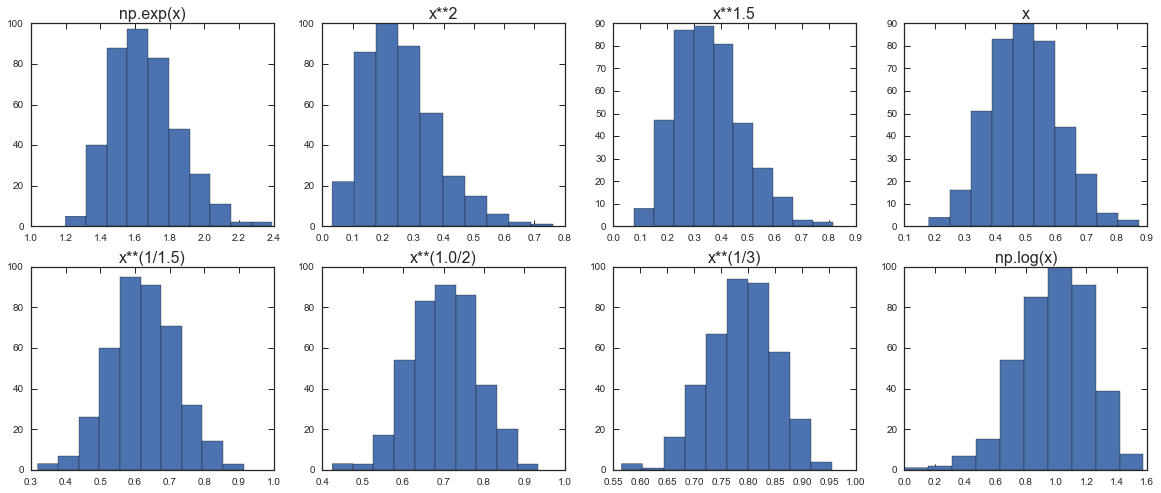

57 first_seen_response_rate_screen+text - Tends to respond to texts immediately


In [265]:
X = Xo[0, :, :].T  # Change shape (1, n, m)  -->  (n, m)

transforms = [
    (lambda x: np.exp(x), "np.exp(x)"),
    (lambda x: x**2, "x**2"),
    (lambda x: x**1.5, "x**1.5"),
    (lambda x: x, "x"),
    (lambda x: x**(1/1.5), "x**(1/1.5)"),
    (lambda x: x**(1.0/2), "x**(1.0/2)"),
    (lambda x: x**(1/3.0), "x**(1/3)"),
    (lambda x: np.log(x+0.00001) - min(np.log(x+0.00001)), "np.log(x)")
]

col_id = 57  # <-- CHOOSE FEATURE ID TO TEST
c = 0
plt.figure(figsize=(20, 8))
for t, s in transforms:
    try:
        tr = t(X[:, col_id])
        if tr[tr<0].any(0):
            print "Warning: transform contains neg. value"
            continue
        if tr[tr==np.inf].any(0):
            print "Warning: transform contains inf. value"
            continue
        c += 1
    except:
        pass
    plt.subplot(2, 4, c)
    plt.title(s, fontsize=16)
    plt.hist(tr)
    
plt.show()

print col_id, cl(feat_names[col_id]), "-", feature_name_map[cl(feat_names[col_id])]

In [ ]:
## sorted(map(lambda x: ((np.log(x[0])), x[1]), [(0.1, 1), (0.2, 2), (0.3, 3), (0.4, 4), (0.5, 5)]), key=lambda x: x[0])

In [266]:
tr_scheme = {
    'number_of_contacts_stop': lambda x: np.log(x),
    'number_of_contacts_text': lambda x: np.log(x),
    'number_of_contacts_call': lambda x: np.log(x),
    'number_of_contacts_physical': lambda x: x,
    'number_of_interactions_stop': lambda x: x,
    'number_of_interactions_text': lambda x: np.log(x),
    'number_of_interactions_call': lambda x: np.log(x),
    'number_of_interactions_physical': lambda x: x**(1/3.0),
    'interactions_per_contact_stop': lambda x: np.log(x),
    'interactions_per_contact_text': lambda x: np.log(x),
    'interactions_per_contact_call': lambda x: np.log(x),
    'interactions_per_contact_physical': lambda x: np.log(x),
    'percent_ei_percent_interactions_text': lambda x: np.log(x),
    'percent_ei_percent_interactions_physical': lambda x: np.log(x),
    'balance_of_interactions_text': lambda x: x,
    'balance_of_interactions_call': lambda x: x,
    'entropy_per_contacts_stop': lambda x: x,
    'entropy_per_contacts_text': lambda x: np.exp(x),
    'entropy_per_contacts_call': lambda x: np.exp(x),
    'entropy_per_contacts_physical': lambda x: np.exp(x),
    'duration_stop': lambda x: np.log(x),
    'duration_text': lambda x: x,
    'duration_screen': lambda x: np.log(x),
    'duration_call': lambda x: np.log(x),
    'duration_physical': lambda x: x,
    'percent_ei_percent_durations_stop': lambda x: np.log(x),
    'percent_ei_percent_durations_call': lambda x: x,
    'percent_initiated_conversations_text_std': lambda x: x**2.0,
    'percent_initiated_conversations_text_mean': lambda x: x,
    'percent_initiated_conversations_call_std': lambda x: x**2.0,
    'percent_initiated_conversations_call_mean': lambda x: x,
    'percent_concluded_conversations_text_std': lambda x: x**2.0,
    'percent_concluded_conversations_text_mean': lambda x: x,
    'percent_concluded_conversations_call_std': lambda x: x**2.0,
    'percent_concluded_conversations_call_mean': lambda x: x,
    'percent_initiated_conversations_call+text_std': lambda x: x,
    'percent_initiated_conversations_call+text_mean': lambda x: x,
    'percent_concluded_conversations_call+text_std': lambda x: x,
    'percent_concluded_conversations_call+text_mean': lambda x: x,
    'overlap_conversations_per_contacts_text': lambda x: np.log(x+0.0001),
    'overlap_conversations_per_contacts_physical': lambda x: np.log(x+0.0001),
    'response_delay_text_std': lambda x: x,
    'response_delay_text_mean': lambda x: x,
    'response_delay_call_std': lambda x: x,
    'response_delay_call_mean': lambda x: x,
    'response_rate_call+text_std': lambda x: x,
    'response_rate_call+text_mean': lambda x: x,
    'percent_nocturnal_screen': lambda x: x,
    'percent_nocturnal_stop': lambda x: x,
    'percent_nocturnal_physical': lambda x: x**(1/3.0),
    'interevent_time_screen': lambda x: np.log(x),
    'fraction_social_screen_alone_screen_screen+physical': lambda x: np.log(x),
    'percent_interactions_campus_physical+stop': lambda x: x,
    'percent_interactions_home_physical+stop': lambda x: np.log(x+0.01),
    'percent_interactions_other_physical+stop': lambda x: np.log(x),
    'percent_outside_campus_from_campus_physical+stop': lambda x: x**(1/2.0),
    'percent_at_campus_stop': lambda x: x,
    'percent_at_home_stop': lambda x: x,
    'percent_at_friday_bar_stop': lambda x: np.log(x+0.00001),
    'percent_contacts_less_stop': lambda x: x,
    'percent_contacts_less_physical': lambda x: x,
    'first_seen_response_rate_screen+text': lambda x: x
}

fi_scheme = {
    'number_of_contacts_stop': lambda x: x >= 0,
    'number_of_contacts_text': lambda x: x >= 0,
    'number_of_contacts_call': lambda x: x >= 0,
    'number_of_contacts_physical': lambda x: x >= 0,
    'number_of_interactions_stop': lambda x: x >= 0,
    'number_of_interactions_text': lambda x: x >= 0,
    'number_of_interactions_call': lambda x: x >= 0,
    'number_of_interactions_physical': lambda x: x >= 0,
    'interactions_per_contact_stop': lambda x: x >= 0,
    'interactions_per_contact_text': lambda x: x >= 0,
    'interactions_per_contact_call': lambda x: x >= 0,
    'interactions_per_contact_physical': lambda x: x >= 0,
    'percent_ei_percent_interactions_text': lambda x: x >= 0,
    'percent_ei_percent_interactions_physical': lambda x: x >= 0,
    'balance_of_interactions_text': lambda x: x >= 0,
    'balance_of_interactions_call': lambda x: x >= 0,
    'entropy_per_contacts_stop': lambda x: x >= 0,
    'entropy_per_contacts_text': lambda x: x >= 0,
    'entropy_per_contacts_call': lambda x: x >= 0,
    'entropy_per_contacts_physical': lambda x: x >= 0,
    'duration_stop': lambda x: x >= 0,
    'duration_text': lambda x: x >= 0,
    'duration_screen': lambda x: x >= 0,
    'duration_call': lambda x: x >= 0,
    'duration_physical': lambda x: x >= 0,
    'percent_ei_percent_durations_stop': lambda x: x >= 0,
    'percent_ei_percent_durations_call': lambda x: x >= 0,
    'percent_initiated_conversations_text_std': lambda x: x >= 0,
    'percent_initiated_conversations_text_mean': lambda x: x >= 0,
    'percent_initiated_conversations_call_std': lambda x: x >= 0,
    'percent_initiated_conversations_call_mean': lambda x: x >= 0,
    'percent_concluded_conversations_text_std': lambda x: x >= 0,
    'percent_concluded_conversations_text_mean': lambda x: x >= 0,
    'percent_concluded_conversations_call_std': lambda x: x >= 0,
    'percent_concluded_conversations_call_mean': lambda x: x >= 0,
    'percent_initiated_conversations_call+text_std': lambda x: x >= 0,
    'percent_initiated_conversations_call+text_mean': lambda x: x >= 0,
    'percent_concluded_conversations_call+text_std': lambda x: x >= 0,
    'percent_concluded_conversations_call+text_mean': lambda x: x >= 0,
    'overlap_conversations_per_contacts_text': lambda x: x >= 0,
    'overlap_conversations_per_contacts_physical': lambda x: x >= 0,
    'response_delay_text_std': lambda x: x >= 0,
    'response_delay_text_mean': lambda x: x >= 0,
    'response_delay_call_std': lambda x: x >= 0,
    'response_delay_call_mean': lambda x: x >= 0,
    'response_rate_call+text_std': lambda x: x >= 0,
    'response_rate_call+text_mean': lambda x: x >= 0,
    'percent_nocturnal_screen': lambda x: x >= 0,
    'percent_nocturnal_stop': lambda x: x >= 0,
    'percent_nocturnal_physical': lambda x: x >= 0,
    'interevent_time_screen': lambda x: x >= 0,
    'fraction_social_screen_alone_screen_screen+physical': lambda x: x >= 0,
    'percent_interactions_campus_physical+stop': lambda x: x >= 0,
    'percent_interactions_home_physical+stop': lambda x: x >= 0,
    'percent_interactions_other_physical+stop': lambda x: x >= 0,
    'percent_outside_campus_from_campus_physical+stop': lambda x: x >= 0,
    'percent_at_campus_stop': lambda x: x >= 0,
    'percent_at_home_stop': lambda x: x > 0.2,
    'percent_at_friday_bar_stop': lambda x: x >= 0,
    'percent_contacts_less_stop': lambda x: x >= 0,
    'percent_contacts_less_physical': lambda x: x >= 0,
    'first_seen_response_rate_screen+text': lambda x: x >= 0
}

In [267]:
Xt = X.copy()
for j, n in enumerate(feat_names):
    try:
        tr = tr_scheme[n]
    except KeyError:
        print "KeyError:", n, "not in tr_scheme. It should be... fix this. Using untransformed variable."
    Xt[:, j] = tr(X[:, j])
    
outliers_filter
for i in range(Xt.shape[0]):
    for j, n in enumerate(feat_names):
        try:
            tr = tr_scheme[n]
        except KeyError:
            print "KeyError:", n, "not in tr_scheme. It should be... fix this. Using untransformed variable."
        

### User averages, zscore and save

In [272]:
#X_users_mean = np.nanmean(X[:, :, :],axis=0).T
Xtz = scale(Xt[~np.isnan(Xt).any(axis=1)])
#np.savetxt("data/X_users_mean.csv", X_users_mean, delimiter=",")

#X_users_mean_tc1 = np.nanmean(X[tc1['weeks'], :, :],axis=0).T
#X_users_mean_tc1 = scale(X_users_mean_tc1[~np.isnan(X_users_mean_tc1).any(axis=1)])
#np.savetxt("data/X_users_mean_tc1.csv", X_users_mean_tc1, delimiter=",")

#X_users_mean_tc2 = np.nanmean(X[tc2['weeks'], :, :],axis=0).T
#X_users_mean_tc2 = scale(X_users_mean_tc2[~np.isnan(X_users_mean_tc2).any(axis=1)])
#np.savetxt("data/X_users_mean_tc2.csv", X_users_mean_tc2, delimiter=",")

#X_users_mean_tc3 = np.nanmean(X[tc3['weeks'], :, :],axis=0).T
#X_users_mean_tc3 = scale(X_users_mean_tc3[~np.isnan(X_users_mean_tc3).any(axis=1)])
#np.savetxt("data/X_users_mean_tc3.csv", X_users_mean_tc3, delimiter=",")

### Detect outliers

In [295]:
out_svm = Outlier_detector_svm(Xtz, hard=False, threshold=0, visualize=False, nu=0.1, gamma=0.25)
out_kd = Outlier_detector_kd(Xtz, visualize=False, threshold=0.1, bandwidth=2, kernel='gaussian')
outliers_svm = out_svm.main()
outliers_kd = out_kd.main()

Xtz_clean_svm = scale(np.delete(Xtz, outliers_svm, axis=0))
Y_clean_svm = np.delete(Yo.T, outliers_svm, axis=0)
M_clean_svm = np.delete(Mo, outliers_svm, axis=0)
Xtz_clean_kd = scale(np.delete(Xtz, outliers_kd, axis=0))
Y_clean_kd = np.delete(Yo.T, outliers_kd, axis=0)
M_clean_kd = np.delete(Mo, outliers_kd, axis=0)

print "[svm] Removed %d outliers, clean subset has %d samples" % (
    (X.shape[0]-Xtz_clean_svm.shape[0]), Xtz_clean_svm.shape[0])
np.savetxt("data/Xtz_clean_svm.csv", Xtz_clean_kd, delimiter=",")
np.savetxt("data/Y_clean_svm.csv", Y_clean_svm, delimiter=",")
np.savetxt("data/M_clean_svm.csv", M_clean_svm, delimiter=",")
np.savetxt("data/XtzYM_clean_svm_valid_users.csv", np.array(valid_userso)[~np.array(outliers_svm)], delimiter=",")
print "[kd] Removed %d outliers, clean subset has %d samples" % (
    (X.shape[0]-Xtz_clean_kd.shape[0]), Xtz_clean_kd.shape[0])
np.savetxt("data/Xtz_clean_kd.csv", Xtz_clean_kd, delimiter=",")
np.savetxt("data/Y_clean_kd.csv", Y_clean_kd, delimiter=",")
np.savetxt("data/M_clean_kd.csv", M_clean_kd, delimiter=",")
np.savetxt("data/XtzYM_clean_kd_valid_users.csv", np.array(valid_userso)[~np.array([i[0] for i in outliers_kd])], delimiter=",")

[svm] Removed 26 outliers, clean subset has 376 samples
[kd] Removed 40 outliers, clean subset has 362 samples


In [ ]:

out_tc1_svm = Outlier_detector_svm(X_users_mean_tc1, hard=False, threshold=-1, visualize=False, nu=0.1, gamma=0.25)
out_tc1_kd = Outlier_detector_kd(X_users_mean_tc1, visualize=False, threshold=0.08, bandwidth=2, kernel='gaussian')
outliers_tc1_svm = out_tc1_svm.main()
outliers_tc1_kd = out_tc1_kd.main()

X_users_mean_tc1_clean_svm = np.delete(X_users_mean_tc1, outliers_tc1_svm, axis=0)
Y_users_mean_tc1_clean_svm = np.delete(Y[0, :, :].T, outliers_tc1_svm, axis=0)
M_users_mean_tc1_clean_svm = np.delete(M, outliers_tc1_svm, axis=0)
X_users_mean_tc1_clean_kd = np.delete(X_users_mean_tc1, outliers_tc1_kd, axis=0)
Y_users_mean_tc1_clean_kd = np.delete(Y[0, :, :].T, outliers_tc1_kd, axis=0)
M_users_mean_tc1_clean_kd = np.delete(M, outliers_tc1_kd, axis=0)

print "[svm tc1] Removed %d outliers, clean subset has %d samples" % (
    (X_users_mean_tc1.shape[0]-X_users_mean_tc1_clean_svm.shape[0]), X_users_mean_tc1_clean_svm.shape[0])
np.savetxt("data/X_users_mean_tc1_clean_svm.csv", X_users_mean_tc1_clean_kd, delimiter=",")
np.savetxt("data/Y_users_mean_tc1_clean_svm.csv", Y_users_mean_tc1_clean_svm, delimiter=",")
np.savetxt("data/M_users_mean_tc1_clean_svm.csv", M_users_mean_tc1_clean_svm, delimiter=",")
np.savetxt("data/X_users_mean_tc1_clean_svm_valid_users.csv", np.array(valid_users)[~np.array(outliers_tc1_svm)], delimiter=",")
print "[kd tc1] Removed %d outliers, clean subset has %d samples" % (
    (X_users_mean_tc1.shape[0]-X_users_mean_tc1_clean_kd.shape[0]), X_users_mean_tc1_clean_kd.shape[0])
np.savetxt("data/X_users_mean_tc1_clean_kd.csv", X_users_mean_tc1_clean_kd, delimiter=",")
np.savetxt("data/Y_users_mean_tc1_clean_kd.csv", Y_users_mean_tc1_clean_kd, delimiter=",")
np.savetxt("data/M_users_mean_tc1_clean_kd.csv", M_users_mean_tc1_clean_kd, delimiter=",")
np.savetxt("data/X_users_mean_tc1_clean_kd_valid_users.csv", np.array(valid_users)[~np.array([i[0] for i in outliers_tc1_kd])], delimiter=",")


out_tc2_svm = Outlier_detector_svm(X_users_mean_tc2, hard=False, threshold=-1, visualize=False, nu=0.1, gamma=0.25)
out_tc2_kd = Outlier_detector_kd(X_users_mean_tc2, visualize=False, threshold=0.08, bandwidth=2, kernel='gaussian')
outliers_tc2_svm = out_tc2_svm.main()
outliers_tc2_kd = out_tc2_kd.main()

X_users_mean_tc2_clean_svm = np.delete(X_users_mean_tc2, outliers_tc2_svm, axis=0)
Y_users_mean_tc2_clean_svm = np.delete(Y[0, :, :].T, outliers_tc2_svm, axis=0)
M_users_mean_tc2_clean_svm = np.delete(M, outliers_tc2_svm, axis=0)
X_users_mean_tc2_clean_kd = np.delete(X_users_mean_tc2, outliers_tc2_kd, axis=0)
Y_users_mean_tc2_clean_kd = np.delete(Y[0, :, :].T, outliers_tc2_kd, axis=0)
M_users_mean_tc2_clean_kd = np.delete(M, outliers_tc2_kd, axis=0)

print "[svm tc2] Removed %d outliers, clean subset has %d samples" % (
    (X_users_mean_tc2.shape[0]-X_users_mean_tc2_clean_svm.shape[0]), X_users_mean_tc2_clean_svm.shape[0])
np.savetxt("data/X_users_mean_tc2_clean_svm.csv", X_users_mean_tc2_clean_kd, delimiter=",")
np.savetxt("data/Y_users_mean_tc2_clean_svm.csv", Y_users_mean_tc2_clean_svm, delimiter=",")
np.savetxt("data/M_users_mean_tc2_clean_svm.csv", M_users_mean_tc2_clean_svm, delimiter=",")
np.savetxt("data/X_users_mean_tc2_clean_svm_valid_users.csv", np.array(valid_users)[~np.array(outliers_tc2_svm)], delimiter=",")
print "[kd tc2] Removed %d outliers, clean subset has %d samples" % (
    (X_users_mean_tc2.shape[0]-X_users_mean_tc2_clean_kd.shape[0]), X_users_mean_tc2_clean_kd.shape[0])
np.savetxt("data/X_users_mean_tc2_clean_kd.csv", X_users_mean_tc2_clean_kd, delimiter=",")
np.savetxt("data/Y_users_mean_tc2_clean_kd.csv", Y_users_mean_tc2_clean_kd, delimiter=",")
np.savetxt("data/M_users_mean_tc2_clean_kd.csv", M_users_mean_tc2_clean_kd, delimiter=",")
np.savetxt("data/X_users_mean_tc2_clean_kd_valid_users.csv", np.array(valid_users)[~np.array([i[0] for i in outliers_tc2_kd])], delimiter=",")


out_tc3_svm = Outlier_detector_svm(X_users_mean_tc3, hard=False, threshold=-1, visualize=False, nu=0.1, gamma=0.25)
out_tc3_kd = Outlier_detector_kd(X_users_mean_tc3, visualize=False, threshold=0.08, bandwidth=2, kernel='gaussian')
outliers_tc3_svm = out_tc3_svm.main()
outliers_tc3_kd = out_tc3_kd.main()

X_users_mean_tc3_clean_svm = np.delete(X_users_mean_tc3, outliers_tc3_svm, axis=0)
Y_users_mean_tc3_clean_svm = np.delete(Y[0, :, :].T, outliers_tc3_svm, axis=0)
M_users_mean_tc3_clean_svm = np.delete(M, outliers_tc3_svm, axis=0)
X_users_mean_tc3_clean_kd = np.delete(X_users_mean_tc3, outliers_tc3_kd, axis=0)
Y_users_mean_tc3_clean_kd = np.delete(Y[0, :, :].T, outliers_tc3_kd, axis=0)
M_users_mean_tc3_clean_kd = np.delete(M, outliers_tc3_kd, axis=0)

print "[svm tc3] Removed %d outliers, clean subset has %d samples" % (
    (X_users_mean_tc3.shape[0]-X_users_mean_tc3_clean_svm.shape[0]), X_users_mean_tc3_clean_svm.shape[0])
np.savetxt("data/X_users_mean_tc3_clean_svm.csv", X_users_mean_tc3_clean_kd, delimiter=",")
np.savetxt("data/Y_users_mean_tc3_clean_svm.csv", Y_users_mean_tc3_clean_svm, delimiter=",")
np.savetxt("data/M_users_mean_tc3_clean_svm.csv", M_users_mean_tc3_clean_svm, delimiter=",")
np.savetxt("data/X_users_mean_tc3_clean_svm_valid_users.csv", np.array(valid_users)[~np.array(outliers_tc3_svm)], delimiter=",")
print "[kd tc3] Removed %d outliers, clean subset has %d samples" % (
    (X_users_mean_tc3.shape[0]-X_users_mean_tc3_clean_kd.shape[0]), X_users_mean_tc3_clean_kd.shape[0])
np.savetxt("data/X_users_mean_tc3_clean_kd.csv", X_users_mean_tc3_clean_kd, delimiter=",")
np.savetxt("data/Y_users_mean_tc3_clean_kd.csv", Y_users_mean_tc3_clean_kd, delimiter=",")
np.savetxt("data/M_users_mean_tc3_clean_kd.csv", M_users_mean_tc3_clean_kd, delimiter=",")
np.savetxt("data/X_users_mean_tc3_clean_kd_valid_users.csv", np.array(valid_users)[~np.array([i[0] for i in outliers_tc3_kd])], delimiter=",")

# Show archetypes

### PCA + PCHA for each individual tc

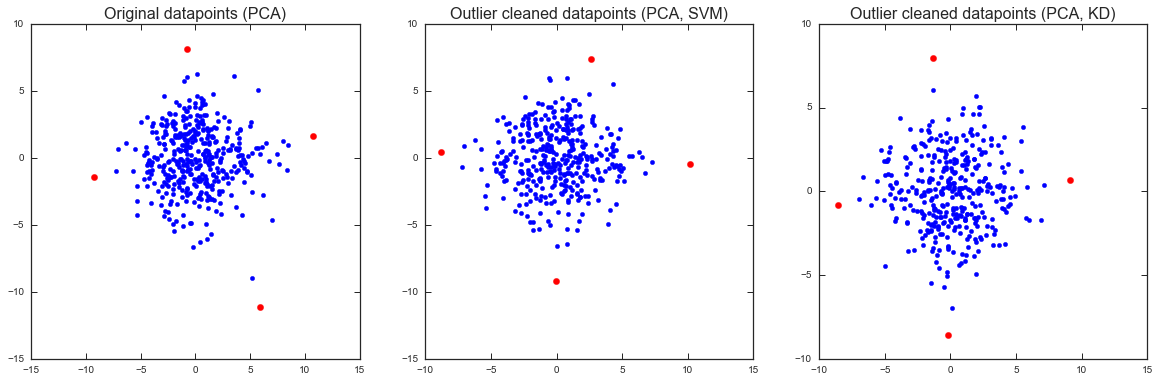

In [296]:
plt.figure(0, figsize=(20,6))

plt.subplot(1,3,1)
plt.title("Original datapoints (PCA)", fontsize=16)

subset = list(set(range(Xtz.shape[1])))# - set([15, 29, 39, 33, 34]))

pca = decomposition.PCA(n_components=2)
X0 = Xtz.copy()[:, subset]
pca.fit(X0)
X0 = pca.transform(X0)
XC, S, C, SSE, varexpl = PCHA(X0.T, 4, delta=0.4)

plt.scatter(X0[:, 0], X0[:, 1], color="b")
plt.scatter(XC[0, :], XC[1, :], color="r", s=40)

plt.subplot(1,3,2)
plt.title("Outlier cleaned datapoints (PCA, SVM)", fontsize=16)

pca = decomposition.PCA(n_components=2)
X0 = np.delete(Xtz, outliers_svm, axis=0)[:, subset]
pca.fit(X0)
X0 = pca.transform(X0)
XC, S, C, SSE, varexpl = PCHA(X0.T, 4, delta=0.4)

plt.scatter(X0[:, 0], X0[:, 1], color="b")
plt.scatter(XC[0, :], XC[1, :], color="r", s=40)

plt.subplot(1,3,3)
plt.title("Outlier cleaned datapoints (PCA, KD)", fontsize=16)

pca = decomposition.PCA(n_components=2)
X0 = np.delete(Xtz, outliers_kd, axis=0)[:, subset]
pca.fit(X0)
X0 = pca.transform(X0)
XC, S, C, SSE, varexpl = PCHA(X0.T, 4, delta=0.4)

plt.scatter(X0[:, 0], X0[:, 1], color="b")
plt.scatter(XC[0, :], XC[1, :], color="r", s=40)

plt.show()

In [ ]:
print "\ntc1"

plt.figure(1, figsize=(20,6))

plt.subplot(1,3,1)
plt.title("Original datapoints (PCA)", fontsize=16)

pca = decomposition.PCA(n_components=2)
X0 = X_users_mean_tc1
pca.fit(X0)
X0 = pca.transform(X0)
XC, S, C, SSE, varexpl = PCHA(X0.T, 3, delta=0.4)

plt.scatter(X0[:, 0], X0[:, 1], color="b")
plt.scatter(XC[0, :], XC[1, :], color="r", s=40)


plt.subplot(1,3,2)
plt.title("Outlier cleaned datapoints (PCA, SVM)", fontsize=16)

pca = decomposition.PCA(n_components=2)
X0 = X_users_mean_tc1_clean_svm
pca.fit(X0)
X0 = pca.transform(X0)
XC, S, C, SSE, varexpl = PCHA(X0.T, 3, delta=0.4)

plt.scatter(X0[:, 0], X0[:, 1], color="b")
plt.scatter(XC[0, :], XC[1, :], color="r", s=40)


plt.subplot(1,3,3)
plt.title("Outlier cleaned datapoints (PCA, KD)", fontsize=16)

pca = decomposition.PCA(n_components=2)
X0 = X_users_mean_tc1_clean_kd
pca.fit(X0)
X0 = pca.transform(X0)
XC, S, C, SSE, varexpl = PCHA(X0.T, 3, delta=0.4)

plt.scatter(X0[:, 0], X0[:, 1], color="b")
plt.scatter(XC[0, :], XC[1, :], color="r", s=40)

plt.show()

print "\ntc2"

plt.figure(2, figsize=(20,6))

plt.subplot(1,3,1)
plt.title("Original datapoints (PCA)", fontsize=16)

pca = decomposition.PCA(n_components=2)
X0 = X_users_mean_tc2
pca.fit(X0)
X0 = pca.transform(X0)
XC, S, C, SSE, varexpl = PCHA(X0.T, 3, delta=0.4)

plt.scatter(X0[:, 0], X0[:, 1], color="b")
plt.scatter(XC[0, :], XC[1, :], color="r", s=40)


plt.subplot(1,3,2)
plt.title("Outlier cleaned datapoints (PCA, SVM)", fontsize=16)

pca = decomposition.PCA(n_components=2)
X0 = X_users_mean_tc2_clean_svm
pca.fit(X0)
X0 = pca.transform(X0)
XC, S, C, SSE, varexpl = PCHA(X0.T, 3, delta=0.4)

plt.scatter(X0[:, 0], X0[:, 1], color="b")
plt.scatter(XC[0, :], XC[1, :], color="r", s=40)


plt.subplot(1,3,3)
plt.title("Outlier cleaned datapoints (PCA, KD)", fontsize=16)

pca = decomposition.PCA(n_components=2)
X0 = X_users_mean_tc2_clean_kd
pca.fit(X0)
X0 = pca.transform(X0)
XC, S, C, SSE, varexpl = PCHA(X0.T, 3, delta=0.4)

plt.scatter(X0[:, 0], X0[:, 1], color="b")
plt.scatter(XC[0, :], XC[1, :], color="r", s=40)

plt.show()

print "\ntc3"

plt.figure(3, figsize=(20,6))

plt.subplot(1,3,1)
plt.title("Original datapoints (PCA)", fontsize=16)

pca = decomposition.PCA(n_components=2)
X0 = X_users_mean_tc3
pca.fit(X0)
X0 = pca.transform(X0)
XC, S, C, SSE, varexpl = PCHA(X0.T, 3, delta=0.4)

plt.scatter(X0[:, 0], X0[:, 1], color="b")
plt.scatter(XC[0, :], XC[1, :], color="r", s=40)


plt.subplot(1,3,2)
plt.title("Outlier cleaned datapoints (PCA, SVM)", fontsize=16)

pca = decomposition.PCA(n_components=2)
X0 = X_users_mean_tc3_clean_svm
pca.fit(X0)
X0 = pca.transform(X0)
XC, S, C, SSE, varexpl = PCHA(X0.T, 3, delta=0.4)

plt.scatter(X0[:, 0], X0[:, 1], color="b")
plt.scatter(XC[0, :], XC[1, :], color="r", s=40)


plt.subplot(1,3,3)
plt.title("Outlier cleaned datapoints (PCA, KD)", fontsize=16)

pca = decomposition.PCA(n_components=2)
X0 = X_users_mean_tc3_clean_kd
pca.fit(X0)
X0 = pca.transform(X0)
XC, S, C, SSE, varexpl = PCHA(X0.T, 3, delta=0.4)

plt.scatter(X0[:, 0], X0[:, 1], color="b")
plt.scatter(XC[0, :], XC[1, :], color="r", s=40)

plt.show()

### All tc datasets projected onto PC1/PC2 for tc0

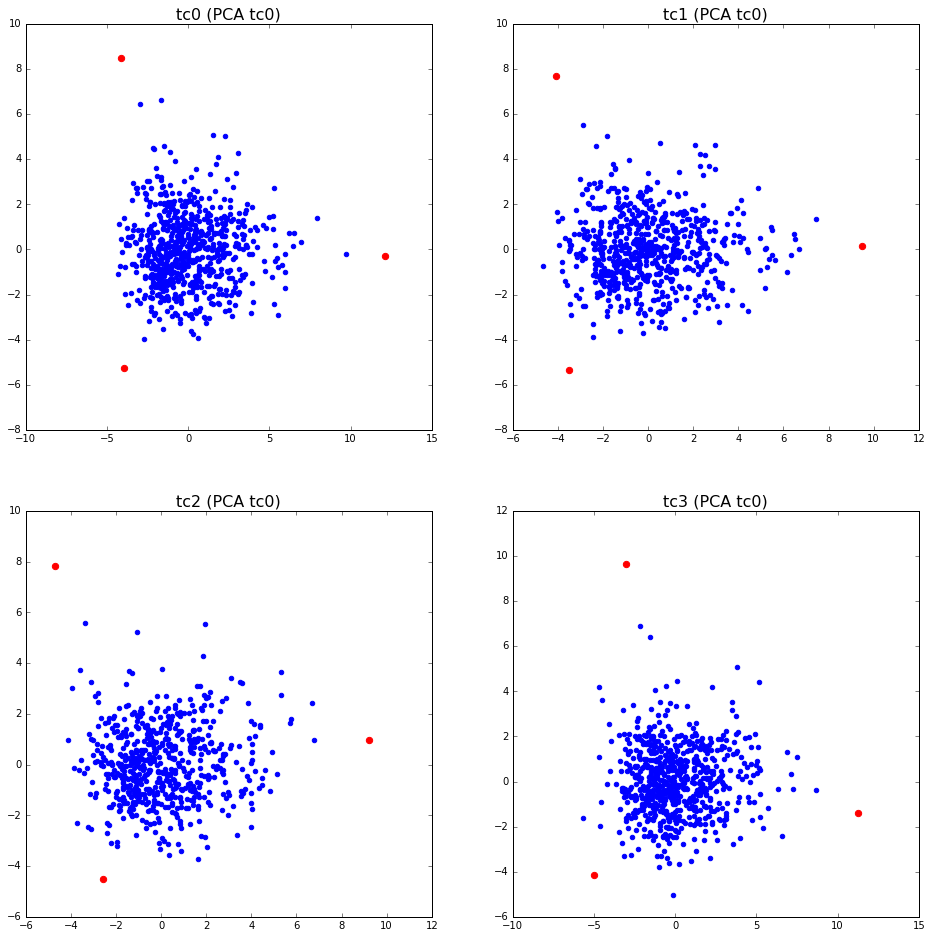

In [17]:
plt.figure(figsize=(16,16))

plt.subplot(2,2,1)
plt.title("tc0 (PCA tc0)", fontsize=16)

X0 = X_users_mean_tc0_clean_kd.T
pca = decomposition.PCA(n_components=2).fit(X0.T)  # <------ Is only fitted here!
X0 = pca.transform(X0.T).T
XC, S, C, SSE, varexpl = PCHA(X0, 3, delta=0.4)

plt.scatter(X0[0, :], X0[1, :], color="b")
plt.scatter(XC[0, :], XC[1, :], color="r", s=40)


plt.subplot(2,2,2)
plt.title("tc1 (PCA tc0)", fontsize=16)

X0 = X_users_mean_tc1_clean_kd.T
X0 = pca.transform(X0.T).T
XC, S, C, SSE, varexpl = PCHA(X0, 3, delta=0.4)

plt.scatter(X0[0, :], X0[1, :], color="b")
plt.scatter(XC[0, :], XC[1, :], color="r", s=40)


plt.subplot(2,2,3)
plt.title("tc2 (PCA tc0)", fontsize=16)

X0 = X_users_mean_tc2_clean_kd.T
X0 = pca.transform(X0.T).T
XC, S, C, SSE, varexpl = PCHA(X0, 3, delta=0.4)

plt.scatter(X0[0, :], X0[1, :], color="b")
plt.scatter(XC[0, :], XC[1, :], color="r", s=40)


plt.subplot(2,2,4)
plt.title("tc3 (PCA tc0)", fontsize=16)

X0 = X_users_mean_tc3_clean_kd.T
X0 = pca.transform(X0.T).T
XC, S, C, SSE, varexpl = PCHA(X0, 3, delta=0.4)

plt.scatter(X0[0, :], X0[1, :], color="b")
plt.scatter(XC[0, :], XC[1, :], color="r", s=40)


plt.show()

# Pareto clustering

In [66]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
import networkx as nx
from collections import defaultdict
from pareto_clustering.cluster.pareto_cluster import Pareto_cluster

### Cap too correlating features

del --x Goes places often
cor --> Goes many different places -- 0.792359354438

del --x Calls many different people
cor --> Texts many different people -- 0.820844750393

del --x Calls often
cor --> Calls many different people -- 0.762097050612

del --x Texts people often compared to number of different people texted
cor --> Texts often -- -0.801071587863

del --x Distributes texts evenly among friends
cor --> Texts often -- -0.796596195119

del --x Meets people often compare to number of people met
cor --> Meets people often -- -0.891693958752

del --x Distributes meetings evenly among friends
cor --> Meets people often -- -0.829494478562

del --x Has unpredictable travel patterns
cor --> Goes places often compare to number of different places went -- 0.756734585576

del --x Distributes texts evenly among friends
cor --> Texts people often compared to number of different people texted -- 0.937532200707

del --x Has unpredictable calling patterns
cor --> Calls people often compared to 

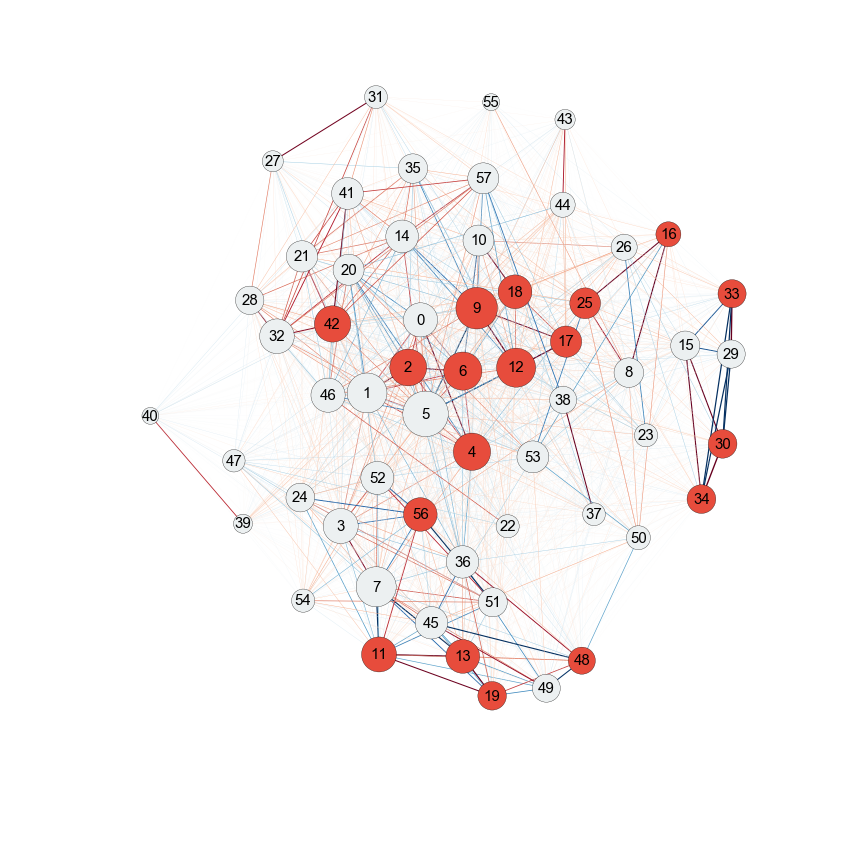

In [444]:
Xtz_clean_svm = np.loadtxt("data/Xtz_clean_svm.csv", delimiter=",")
Xtz_clean_svm_valid_users = np.loadtxt("data/Xtz_clean_svm_valid_users.csv", delimiter=",")
feat_names = np.load("data/X_2014_%s_feat_names.pickle" % None)

X = Xtz_clean_svm
valid_users = Xtz_clean_svm_valid_users

feat_blacklist = []

sigma = np.corrcoef(X.T)
remove_cols = []

G = nx.Graph()

cutoff = 0.7
for i in range(sigma.shape[0]):
    for j in range(sigma.shape[1]):
        
        G.add_edge(i, j, weight=abs(sigma[i, j]), color=sigma[i, j])
        
        if i >= j:# or j in remove_cols:
            continue
            
        if abs(sigma[i, j]) > cutoff:
            print "del --x", 
            print feature_name_map[cl(feat_names[j])]
            print "cor --> %s --"% feature_name_map[cl(feat_names[i])],
            print sigma[i, j]
            print
            
            remove_cols.append(j)

## ASSIGN
X = np.delete(X, remove_cols, axis=1)
feat_names = [cl(fn) for i, fn in enumerate(feat_names) if i not in remove_cols]


## SHOW GRAPH OF CORRELATION COEF MATRIX WITH CAP ENFORCED
plt.figure(figsize=(12,12))
plt.axis('off')
plt.tight_layout()

pos = nx.spring_layout(G, k=0.2)

edge_widths = np.log(np.array([abs(G[u][v]['weight']) for u,v in G.edges()])+1)*2
edge_colors = np.array([G[u][v]['color']  for u,v in G.edges()]).clip(min=-cutoff, max=cutoff)

degrees = [G.degree(weight='weight')[n] for n in G.nodes()]
node_sizes = (np.array(degrees)/np.mean(degrees)*30)**2
node_colors = ['#e74c3c' if n in remove_cols else '#ecf0f1' for n in G.nodes()]

label_names = dict((n, n) for n in G.nodes()) # ''.join(feat_names[n].split("_allweek__allday__"))

edges = nx.draw_networkx_edges(G, pos=pos, width=edge_widths, edge_color=edge_colors, edge_cmap=plt.cm.RdBu_r)
nodes = nx.draw_networkx_nodes(G, pos=pos, with_labels=False, node_size=node_sizes, node_color=node_colors)
labels = nx.draw_networkx_labels(G, pos=pos, font_size=15, labels=label_names)

plt.show()

In [298]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.5, min_samples=2, metric='precomputed').fit(1-sigma)
sorted(zip(db.labels_,feat_names), key=lambda x: x[0])

[(-1, 'duration_stop'),
 (-1, 'duration_screen'),
 (-1, 'duration_call'),
 (-1, 'duration_physical'),
 (-1, 'percent_ei_percent_durations_call'),
 (-1, 'overlap_conversations_per_contacts_text'),
 (-1, 'interevent_time_screen'),
 (-1, 'fraction_social_screen_alone_screen_screen+physical'),
 (-1, 'percent_interactions_other_physical+stop'),
 (-1, 'percent_at_home_stop'),
 (-1, 'percent_at_friday_bar_stop'),
 (-1, 'percent_contacts_less_stop'),
 (0, 'number_of_contacts_stop'),
 (0, 'number_of_contacts_text'),
 (0, 'number_of_contacts_call'),
 (0, 'number_of_interactions_stop'),
 (0, 'number_of_interactions_text'),
 (0, 'number_of_interactions_call'),
 (0, 'balance_of_interactions_text'),
 (0, 'duration_text'),
 (0, 'percent_initiated_conversations_text_mean'),
 (0, 'percent_concluded_conversations_text_mean'),
 (0, 'response_rate_call+text_std'),
 (0, 'response_rate_call+text_mean'),
 (0, 'first_seen_response_rate_screen+text'),
 (1, 'number_of_contacts_physical'),
 (1, 'number_of_intera

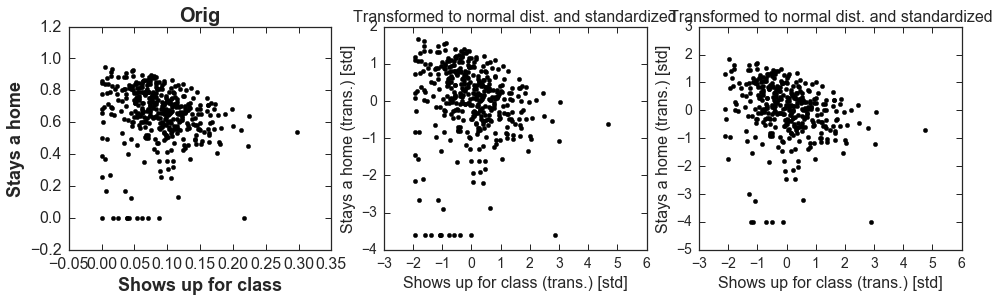

In [446]:
#X1 = X_users_mean_tc0_clean_svm
X1 = Xo[0, :, :].T


feat_i_n = 'Shows up for class'
feat_j_n = 'Stays at home'

feat_i = dict((v, k) for k, v in feature_name_map.items())[feat_i_n]
feat_j = dict((v, k) for k, v in feature_name_map.items())[feat_j_n]

i = map(cl, feat_nameso).index(feat_i)
j = map(cl, feat_nameso).index(feat_j)

plt.figure(figsize=(16, 4))
sns.set_style("ticks", {"xtick.direction": "in", "ytick.direction": "in"})  # <-- STYLE

plt.subplot(1,3,1)
plt.title("Orig", fontsize=20, fontweight='bold')
plt.scatter(X1[:, i], X1[:, j], c="k")
plt.xlabel(feat_i_n, fontsize=18, fontweight='bold')
plt.ylabel(feat_j_n, fontsize=18, fontweight='bold')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(1,3,2)
plt.title("Transformed to normal dist. and standardized", fontsize=16)
plt.scatter(scale(tr_scheme[feat_i](X1[:, i])), scale(tr_scheme[feat_j](X1[:, j])), c="k")
plt.xlabel("%s (trans.) [std]" % feat_i_n, fontsize=16)
plt.ylabel("%s (trans.) [std]" % feat_j_n, fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(1,3,3)
plt.title("Transformed to normal dist. and standardized", fontsize=16)
plt.scatter(Xtz_clean_kd[:, i], Xtz_clean_kd[:, j], c="k")
plt.xlabel("%s (trans.) [std]" % feat_i_n, fontsize=16)
plt.ylabel("%s (trans.) [std]" % feat_j_n, fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

In [ ]:
X1 = Xo[0, :, :].T


feat_i_n = 'Calls often'
feat_j_n = 'Makes more calls then receives'

feat_i = dict((v, k) for k, v in feature_name_map.items())[feat_i_n]
feat_j = dict((v, k) for k, v in feature_name_map.items())[feat_j_n]

i = map(cl, feat_nameso).index(feat_i)
j = map(cl, feat_nameso).index(feat_j)

plt.figure(figsize=(14, 6))
sns.set_style("ticks", {"xtick.direction": "in", "ytick.direction": "in"})  # <-- STYLE

plt.subplot(1,2,1)
plt.title("Calls received vs. calls made", fontsize=20, fontweight='bold')
plt.scatter(X1[:, i] * X1[:, j], X1[:, i] - X1[:, i] * X1[:, j], c="k")
plt.xlabel("No. calls made", fontsize=18, fontweight='bold')
plt.ylabel("No. calls received", fontsize=18, fontweight='bold')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim([-150, 3000])
plt.ylim([-100, 1100])

plt.subplot(1,2,2)
plt.title("Total no. calls vs. percent calls made", fontsize=20, fontweight='bold')
plt.scatter(X1[:, j], X1[:, i], c="k")
plt.xlabel("Percent of calls going out", fontsize=18, fontweight='bold')
plt.ylabel("No. calls made and received", fontsize=18, fontweight='bold')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim([0.4, 1])
plt.ylim([-100, 3250])

plt.tight_layout(pad=0.4, w_pad=5, h_pad=1.0)
plt.savefig(FIGPATH + "example_informative_features.pdf")

In [71]:
pd.DataFrame(Xo[0, [3, 47], :].T)

,0,1
0,217,0.567675
1,32,0.800184
2,218,0.358728
3,224,0.393223
4,237,0.516448
5,197,0.608237
6,146,0.308289
7,117,0.894185
8,86,2.909718
9,428,1.042348


In [92]:
X1[:, 43].shape

(561,)

In [28]:
#ds = defaultdict(list)
#for i in G.nodes():
#    ds['nodes'].append({"name": feat_names[i], "size": node_sizes[i], "label": i})
#    for j in G.nodes():
#        if i >= j:
#            continue
#        
#        ds['links'].append({'source': i, 'target': j, 'value': G[i][j]['weight'], 'color': np.sign(G[i][j]['color'])})


In [29]:
#filepath = '/Users/ulfaslak/Dropbox/school/sem12/MScProject/Academic/code/pipeline_code/visualisation/feature_correlation/data/'
#with open(filepath + 'ds.json', 'w') as outfile:
#    outfile.write(json.dumps(ds, indent=4))

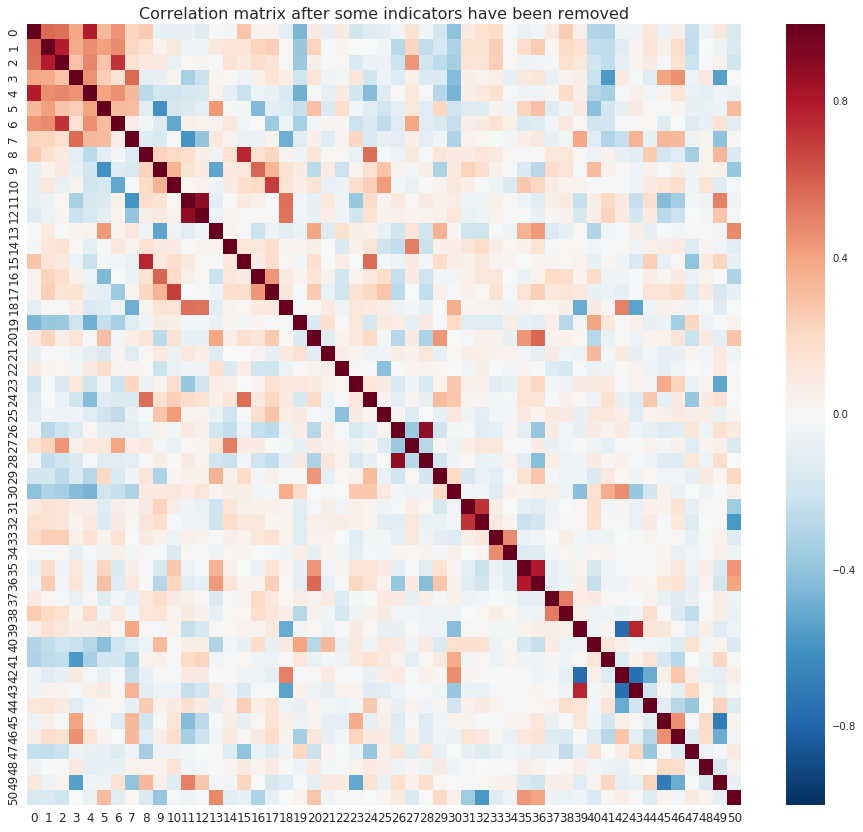

[(0, 'Goes many different places'),
 (1, 'Texts many different people'),
 (2, 'Calls many different people'),
 (3, 'Meets many different people'),
 (4, 'Goes places often'),
 (5, 'Texts often'),
 (6, 'Calls often'),
 (7, 'Meets people often'),
 (8, 'Goes places often compare to number of different places went'),
 (9, 'Texts people often compared to number of different people texted'),
 (10, 'Calls people often compared to number of different people called'),
 (11, 'Meets people often compare to number of people met'),
 (12, 'Distributes meetings evenly among friends'),
 (13, 'Sends more texts than receives'),
 (14, 'Makes more calls then receives'),
 (15, 'Has unpredictable travel patterns'),
 (16, 'Has unpredictable texting patterns'),
 (17, 'Has unpredictable calling patterns'),
 (18, 'Has unpredictable social meeting patterns'),
 (19, 'Spends long time at locations'),
 (20, 'Has long text conversations'),
 (21, 'Has long phone usage sessions'),
 (22, 'Makes long calls'),
 (23, 'Spen

In [41]:
plt.figure(figsize=(16,14))
plt.title("Correlation matrix after some indicators have been removed", fontsize=16)
sns.heatmap(pd.DataFrame(np.corrcoef(X.T)))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
[(i, '_'.join(n.split("__allweek__allday__"))) for i, n in enumerate(feat_names)]

In [31]:
pareto_cluster = Pareto_cluster(num_iter=10, sample_size=1.0, remove_outliers=True, visualize=True)
pareto_cluster.fit(X)

ImportError: No module named p2t

In [44]:
clusters_infomap = pareto_cluster.Infomap()
clusters_dbscan = pareto_cluster.DBSCAN()

3 clusters and 0 outliers
3 clusters and 1 outliers
3 clusters and 2 outliers
3 clusters and 3 outliers
3 clusters and 7 outliers
3 clusters and 8 outliers
3 clusters and 9 outliers
	... found 1 valid solutions, using eps=1.854227, min_samples=11 (minimal params)


In [49]:
clusters_dbscan

array([-1,  0, -1,  1, -1,  0, -1, -1,  1,  0,  1,  1,  1, -1,  1,  0, -1,
        2,  0,  2,  1,  0,  0,  0,  0,  0, -1,  2,  1,  2,  0,  1,  1,  1,
        1,  0,  2,  1, -1])

In [46]:
from itertools import groupby
import json

#clusters_dbscan = pareto_cluster.DBSCAN()

groups = []
for _, g in groupby(sorted(zip(clusters_dbscan, feat_names), key=lambda x: x[0]), key=lambda x: x[0]):
    groups.append([e[1] for e in g])

for g in groups:
    print json.dumps(g, indent=2)

[
  "number_of_contacts__allweek__allday__stop", 
  "number_of_contacts__allweek__allday__call", 
  "duration__allweek__allday__stop", 
  "duration__allweek__allday__screen", 
  "duration__allweek__allday__call", 
  "percent_concluded_conversations__allweek__allday__call+text_mean", 
  "overlap_conversations_per_contacts__allweek__allday__physical", 
  "entropy_per_contacts__allweek__allday__physical", 
  "overlap_screen_physical__allweek__allday__screen+physical"
]
[
  "number_of_contacts__allweek__allday__text", 
  "duration__allweek__allday__text", 
  "percent_nocturnal__allweek__allday__screen", 
  "overlap_conversations_per_contacts__allweek__allday__text", 
  "response_delay__allweek__allday__text_std", 
  "response_rate__allweek__allday__call+text_mean", 
  "response_rate__allweek__allday__call+text_std", 
  "entropy_per_contacts__allweek__allday__stop", 
  "entropy_per_contacts__allweek__allday__text", 
  "entropy_per_contacts__allweek__allday__call", 
  "interactions_per_conta

In [127]:
print feat_names[2]
print feat_names[30]

number_of_contacts__allweek__allday__call
number_of_interactions__allweek__allday__call


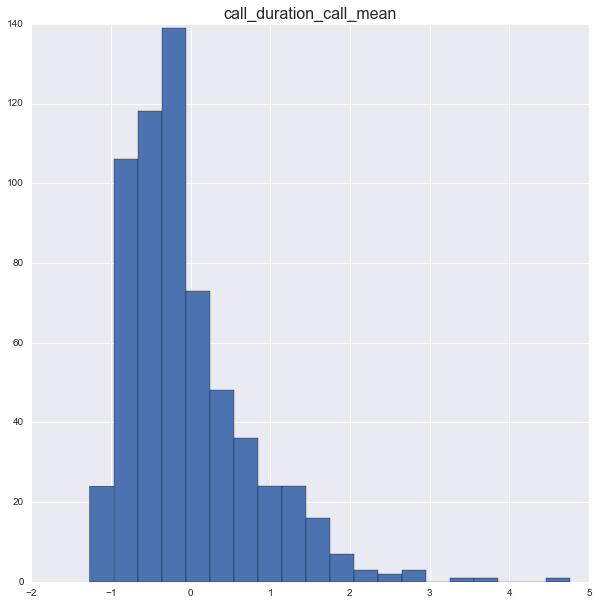

In [110]:
j = 4
plt.figure(figsize=(10,10))
plt.title(''.join(feat_names[j].split("_allweek__allday__")), fontsize=16)
plt.hist(X[:, j], bins=20)
plt.show()

In [512]:
def time_correlated_entropy(walk):
    counter = Counter(zip(walk[:-1], walk[1:]))
    P = np.array(counter.values(), float) / np.sum(counter.values())
    return - sum(P * np.log2(P))

def shannon_entropy(data):
    data = np.array(Counter(walk).values()) * 1.0/ len(data)
    data = data *1.0 / sum(data)
    return - sum(
        data * np.log2(data)
    )

In [ ]:
x_call, y_call, z_call = [], [], []
x_text, y_text, z_text = [], [], []
x_physical, y_physical, z_physical = [], [], []
x_stop, y_stop, z_stop = [], [], []
    
    walk = [r.correspondent_id for r in user.physical_records]
    n = len(set(walk))
    x_physical.append(n)
    y_physical.append(shannon_entropy(walk))
    z_physical.append(time_correlated_entropy(walk))
    
    walk = [r.correspondent_id for r in user.call_records]
    x_call.append(n)
    y_call.append(shannon_entropy(walk))
    z_call.append(time_correlated_entropy(walk))

    walk = [r.correspondent_id for r in user.text_records]
    x_text.append(n)
    y_text.append(shannon_entropy(walk))
    z_text.append(time_correlated_entropy(walk))
    
    walk = [r.position for r in user.stop_records]
    x_stop.append(n)
    y_stop.append(shannon_entropy(walk))
    z_stop.append(time_correlated_entropy(walk))

In [39]:
def _processed_users(tc):
    interaction_types = ["call", "text", "physical", "screen", "stop"]
    counter = Counter()
    for t in interaction_types:
        users = [int(f.split(".")[0]) for f in os.listdir("build_dataset/data_cache/records/%s/%s" % (t, tc))]
        counter.update(users)
    return [k for k,v in counter.items() if v == 5]

def _threshold_test(user):
    def __recs_per_day(records):
        counter = len(records) * 1.0
        span = (max(records, key=lambda r: r.datetime).datetime - \
                min(records, key=lambda r: r.datetime).datetime).days
        return counter/span
    
    thresholds = [
        (user.text_records, 2),
        (user.call_records, 1),
        (user.physical_records, 1),
        (user.screen_records, 20),
        (user.stop_records, 1)
    ]
    
    for records, thr in thresholds:
        if __recs_per_day(records) < thr:
            return False
    return True

users_records = {}
users_below_thresh = []
tc = "tc0"
for u in _processed_users(tc):
    user = bc_d.read_csv(
        "%d" % u, 
        call_path="build_dataset/data_cache/records/call/%s/" % tc,
        text_path="build_dataset/data_cache/records/text/%s/" % tc,
        physical_path="build_dataset/data_cache/records/physical/%s/" % tc,
        screen_path="build_dataset/data_cache/records/screen/%s/" % tc, 
        stop_path="build_dataset/data_cache/records/stop/%s/" % tc, 
        network=False,
        describe=False
    )
    try:
        if not _threshold_test(user):
            users_below_thresh.append(u)
            
        users_records[u] = {
            "call": len(user.call_records) * 1.0 / (max(user.call_records, key=lambda r: r.datetime).datetime - min(user.call_records, key=lambda r: r.datetime).datetime).days ,
            "text": len(user.text_records) * 1.0 / (max(user.text_records, key=lambda r: r.datetime).datetime - min(user.text_records, key=lambda r: r.datetime).datetime).days ,
            "physical": len(user.physical_records) * 1.0 / (max(user.physical_records, key=lambda r: r.datetime).datetime - min(user.physical_records, key=lambda r: r.datetime).datetime).days ,
            "screen": len(user.screen_records) * 1.0 / (max(user.screen_records, key=lambda r: r.datetime).datetime - min(user.screen_records, key=lambda r: r.datetime).datetime).days ,
            "stop": len(user.stop_records) * 1.0 / (max(user.stop_records, key=lambda r: r.datetime).datetime - min(user.stop_records, key=lambda r: r.datetime).datetime).days 
        }
    except ZeroDivisionError:
        print u
        users_below_thresh.append(u)

25
134
763
809
811


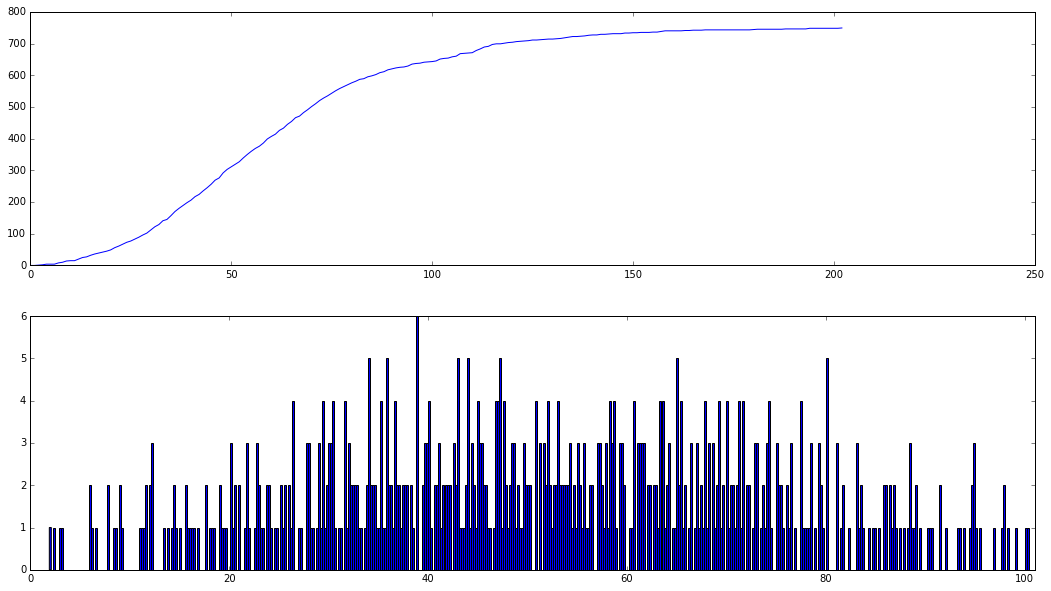

In [32]:
dtype="screen"
maxval = int(max([v[dtype] for v in users_records.values()])) + 1

y = []
for i in range(maxval):
    y.append(len([v[dtype] for v in users_records.values() if v[dtype] < i]))

plt.figure(figsize=(18,10))
plt.subplot(2,1,1)
plt.plot(range(maxval), y)
plt.subplot(2,1,2)
plt.hist([v[dtype] for _, v in users_records.items()], bins=1000)
plt.xlim([0, maxval/2])
plt.show()

In [40]:
len(users_below_thresh)

143

In [322]:
a, b = [], []

for u in range(500):
    tc = "tc0"
    user = bc_d.read_csv(
                "%d" % u, 
                #call_path="build_dataset/data_cache/records/call/%s/" % tc,
                #text_path="build_dataset/data_cache/records/text/%s/" % tc,
                physical_path="build_dataset/data_cache/records/physical/%s/" % tc,
                #screen_path="build_dataset/data_cache/records/screen/%s/" % tc, 
                stop_path="build_dataset/data_cache/records/stop/%s/" % tc, 
                network=False,
                describe=False
            )
    records = sorted(user.physical_records + user.stop_records, key=lambda r: r.datetime)
    try:
        x, y = percent_outside_campus_from_campus(records)
    except ZeroDivisionError:
        print u
        continue
    a.append(x)
    b.append(y)

41
60
176
212
260
316
417
454
484
490


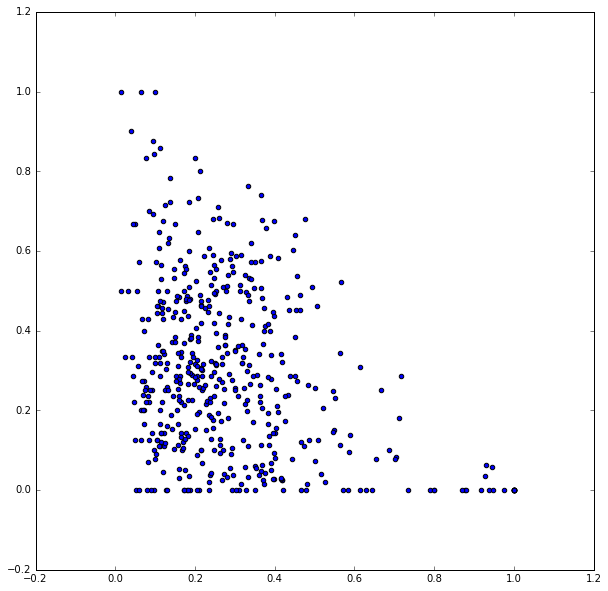

In [323]:
plt.figure(figsize=(10,10))
plt.scatter(a, b)
plt.show()

In [371]:
(dt.fromtimestamp(1111111111) - dt.fromtimestamp(1114111111)).days

-35

In [135]:
import datetime

def entropy(data):
    """
    Compute the Shannon entropy, a measure of uncertainty.
    """
    if len(data) == 0:
        return None
    _op = lambda f: f * np.log2(f)
    return - sum(_op(float(i) / sum(data)) for i in data)

def entropy_per_contacts(records, normalize=True):
    """Entropy of the user's contacts. Time uncorrelated.

    Parameters
    ----------
    normalize: boolean, default is False
        Returns a normalized entropy between 0 and 1.
    """
    try:
        counter = Counter(r.correspondent_id for r in records)
    except AttributeError:
        counter = Counter(r.position for r in records)

    raw_entropy = entropy(counter.values())
    n = len(counter)
    if normalize and n > 1:
        return raw_entropy / n
    else:
        return raw_entropy


x_call, y_call = [], []
x_text, y_text = [], []
x_physical, y_physical = [], []
x_screen, y_screen = [], []
x_stop, y_stop = [], []

tc = "tc0"
for u in _processed_users(tc):
    user = bc_d.read_csv(
        "%d" % u, 
        call_path="build_dataset/data_cache/records/call/%s/" % tc,
        text_path="build_dataset/data_cache/records/text/%s/" % tc,
        physical_path="build_dataset/data_cache/records/physical/%s/" % tc,
        #screen_path="build_dataset/data_cache/records/screen/%s/" % tc,
        stop_path="build_dataset/data_cache/records/stop/%s/" % tc,
        network=False,
        describe=False
    )
    
    x_call.append(entropy_per_contacts(user.call_records))
    y_call.append(len(user.call_records))

    x_text.append(entropy_per_contacts(user.text_records))
    y_text.append(len(user.text_records))

    x_physical.append(entropy_per_contacts(user.physical_records))
    y_physical.append(len(user.physical_records))

    x_stop.append(entropy_per_contacts(user.stop_records))
    y_stop.append(len(user.stop_records))

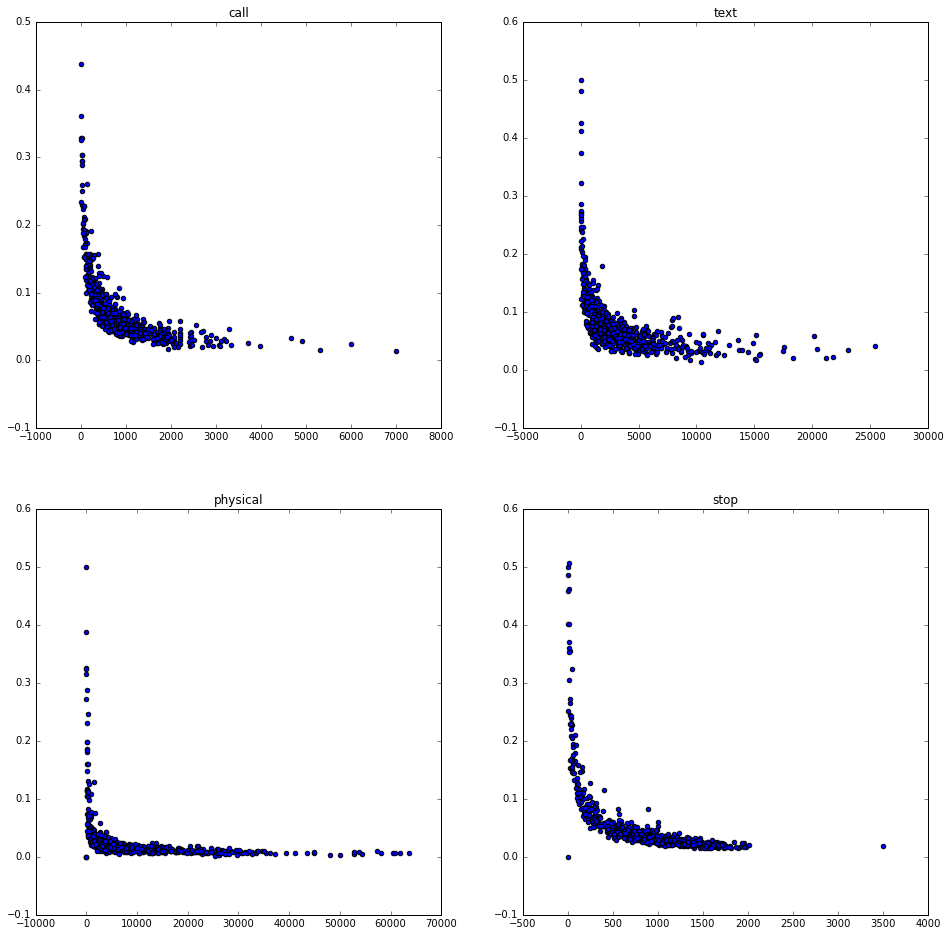

In [136]:
plt.figure(figsize=(16, 16))
plt.subplot(2, 2, 1)
plt.title("call")
plt.scatter(y_call, x_call)
plt.subplot(2, 2, 2)
plt.title("text")
plt.scatter(y_text, x_text)
plt.subplot(2, 2, 3)
plt.title("physical")
plt.scatter(y_physical, x_physical)
plt.subplot(2, 2, 4)
plt.title("stop")
plt.scatter(y_stop, x_stop)
plt.show()

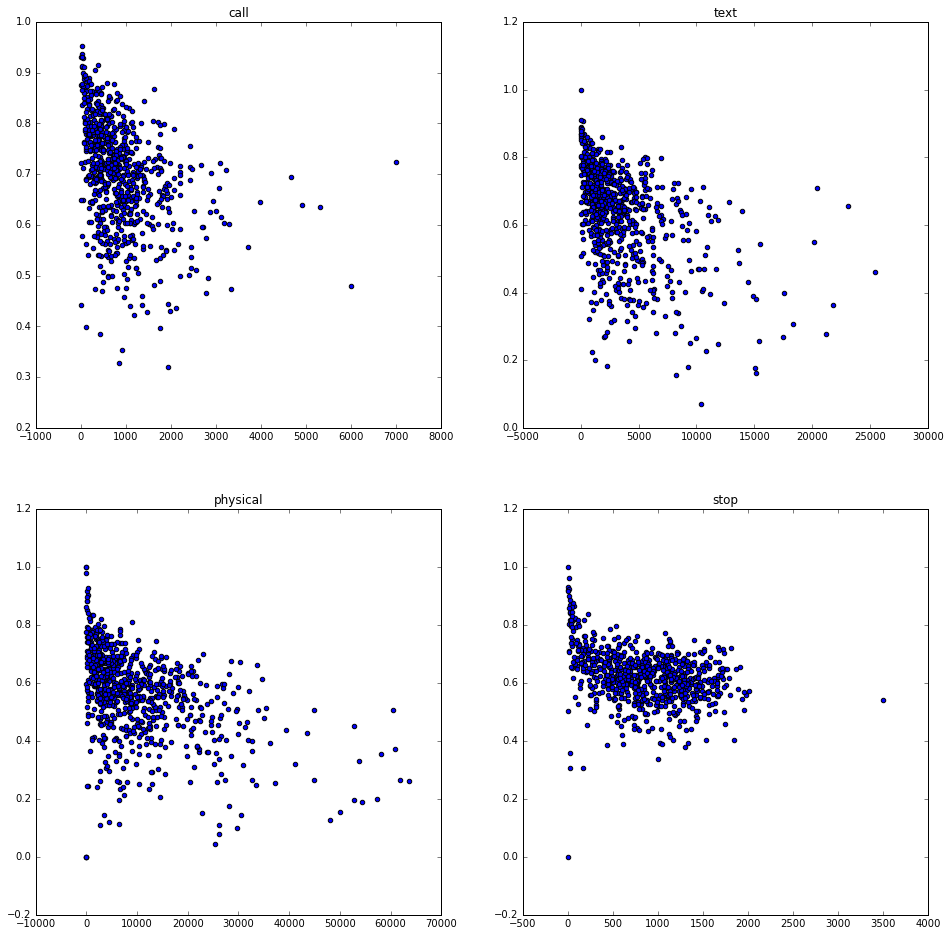

In [134]:
plt.figure(figsize=(16, 16))
plt.subplot(2, 2, 1)
plt.title("call")
plt.scatter(y_call, x_call)
plt.subplot(2, 2, 2)
plt.title("text")
plt.scatter(y_text, x_text)
plt.subplot(2, 2, 3)
plt.title("physical")
plt.scatter(y_physical, x_physical)
plt.subplot(2, 2, 4)
plt.title("stop")
plt.scatter(y_stop, x_stop)
plt.show()

In [21]:
import datetime
from collections import defaultdict
def _conversations_ext(group, delta=datetime.timedelta(hours=1)):
    """Return iterator of grouped conversations.

    See :ref:`Using bandicoot <conversations-label>` for a definition of conversations.

    A conversation begins when one person sends a text-message to the other and ends when one of them makes a phone call
    or there is no activity between them for an hour.  
    """
    last_time = None
    results = []
    for g in group:
        if last_time is None or g.datetime - last_time < delta:
            results.append(g)
            if g.interaction == "call" and g.duration > 1:
                yield results
                results = []

        else:
            if len(results) != 0:
                yield results
            results = [g]

        last_time = g.datetime

    if len(results) != 0:
        yield results

def fraction_social_screen_alone_screen(records):
    """Percent of screen time that overlaps with physical interaction time.

    The following illustrates the concept of overlap. '-' denotes active conversation,
    '_' is idle time, and * underscores overlap. Each symbol is 1 minute.
        
        Conversation 1: ___-----______   # Overlap of two conversations. The total 
        Conversation 2: ______--------   # conversation time 11 minutes and overlap
        Conve. overlap:       **         # is 2 minutes: results in 2/11 overlap.

    #See :ref:`Using bandicoot <conversations-label>` for a definition of conversations.
    """
    records = list(records)

    interactions = defaultdict(list)
    for r in records:
        if r.interaction == "physical":
            interactions[r.correspondent_id].append(r)

    def _timespans_physical(grouped):
        to_ts = lambda dt: int(dt.strftime("%s"))
        ts = [(to_ts(conv[0].datetime), to_ts(conv[-1].datetime))
              for conv in _conversations_ext(grouped, datetime.timedelta(hours=1.0/12))]
        return ts

    def _timespans_screen(r):
        to_ts = lambda dt: int(dt.strftime("%s"))
        return to_ts(r.datetime), to_ts(r.datetime) + r.duration

    timestamps_screen = [
        ts 
        for r in records if r.interaction == "screen"
        for ts in xrange(*_timespans_screen(r))
    ]

    timestamps_physical = [
        ts
        for i in interactions.values()
        for a, b in _timespans_physical(i)
        for ts in xrange(a, b)
    ]
    
    if len(timestamps_physical) == 0:
        return None

    overlap_screen_physical = len(set(timestamps_screen) & set(timestamps_physical)) * 1.0 / len(timestamps_physical)
    overlap_screen_alone = len(set(timestamps_screen) - set(timestamps_physical)) * 1.0 / (max(timestamps_screen) - min(timestamps_screen) - len(timestamps_physical))

    return overlap_screen_physical * 1.0 / overlap_screen_alone

In [22]:
tc = "tc0"
user = bc_d.read_csv(
    "%d" % 0, 
    call_path="build_dataset/data_cache/records/call/%s/" % tc,
    text_path="build_dataset/data_cache/records/text/%s/" % tc,
    physical_path="build_dataset/data_cache/records/physical/%s/" % tc,
    screen_path="build_dataset/data_cache/records/screen/%s/" % tc,
    stop_path="build_dataset/data_cache/records/stop/%s/" % tc,
    network=False,
    describe=True
)

[x] 1164 call_records from 2014-01-01 01:32:01 to 2014-12-30 19:23:08
[x] 3598 text_records from 2014-01-01 07:29:06 to 2014-12-30 19:08:13
[x] 23827 physical_records from 2014-01-05 16:25:29 to 2014-12-29 14:01:57
[x] 41583 screen_records from 2014-01-01 01:16:52 to 2014-12-30 23:52:34
[x] 1578 stop_records from 2014-01-02 18:45:00 to 2014-12-30 18:45:00
[x] 362 contacts
[ ] No attribute stored
[x] Has texts
[x] Has calls
[ ] No network


In [20]:
records = sorted(user.screen_records + user.physical_records, key=lambda r: r.datetime)
fraction_social_screen_alone_screen(records)

overlap_screen_physical 0.0792391891745
overlap_screen_alone 0.139585551266
max(timestamps_screen) 1419983700
min(timestamps_screen) 1388539012
max(timestamps_screen) - min(timestamps_screen) 31444688
len(timestamps_physical) 2205752


0.5676747231761481

In [555]:
x = (xrange(10000) for _ in range(10))

In [558]:
type(x.next())

xrange

In [559]:
from datetime import datetime as dt

def long_short(n):
    x = (xrange(10) for _ in xrange(n))

    start = dt.now()
    counter = 0
    for i in x:
        for j in i:
            counter += 1

    return (dt.now() - start).microseconds

def short_long(n):
    x = (xrange(n) for _ in xrange(10))

    start = dt.now()
    counter = 0
    for i in x:
        for j in i:
            counter += 1

    return (dt.now() - start).microseconds

In [551]:
%timeit a = long_short(100000)

10 loops, best of 3: 67.1 ms per loop


In [552]:
%timeit b = short_long(100000)

10 loops, best of 3: 41.8 ms per loop


1000 11000 21000 31000 41000 51000 61000 71000 81000 91000 101000 111000 121000 131000 141000 151000 161000 171000 181000 191000 201000 211000 221000 231000 241000 251000 261000 271000 281000 291000 301000 311000 321000 331000 341000 351000 361000 371000 381000 391000 401000 411000 421000 431000 441000 451000 461000 471000 481000 491000 501000 511000 521000 531000 541000 551000 561000 571000 581000 591000 601000 611000 621000 631000 641000 651000 661000 671000 681000 691000 701000 711000 721000 731000 741000 751000 761000 771000 781000 791000 801000 811000 821000 831000 841000 851000 861000 871000 881000 891000 901000 911000 921000 931000 941000 951000 961000 971000 981000 991000

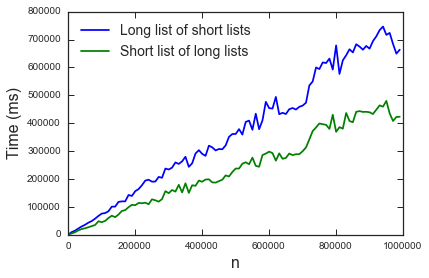

In [560]:
x, ls, sl = [], [], []
for i, n in enumerate(range(1000, 1000000, 10000)):
    x.append(n)
    ls.append(long_short(n))
    sl.append(short_long(n))
    print n,

plt.figure()
ax1 = plt.plot(x, ls, c="b", label="Long list of short lists")
ax2 = plt.plot(x, sl, c="g", label="Short list of long lists")
plt.xlabel("n", fontsize=16)
plt.ylabel("Time (ms)", fontsize=16)
plt.legend(loc=2, fontsize=14)
plt.show()

In [522]:
print y1[-1]
print y2[-1]

492783
397067


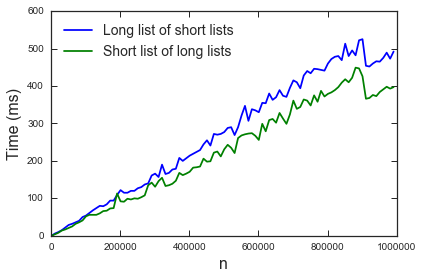

In [520]:
plt.figure()
ax1 = plt.plot(np.array(x), np.array(y1)/1000, c="b", label="Long list of short lists")
ax2 = plt.plot(np.array(x), np.array(y2)/1000, c="g", label="Short list of long lists")
plt.xlabel("n", fontsize=16)
plt.ylabel("Time (ms)", fontsize=16)
plt.legend(loc=2, fontsize=14)
plt.tight_layout()
plt.savefig("tmp.png")

In [523]:
%timeit long_short(10000)

100 loops, best of 3: 5.12 ms per loop


In [524]:
%timeit short_long(10000)

100 loops, best of 3: 4.72 ms per loop


indicators = bc_d.utils.all(
    user,
    groupby=None,
    dist=True,
    network=False,
    spatial=False
)